In [62]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset as BaseDataset


class UdderDataset(BaseDataset):
    """Dataset for Udder Segmentation and Classification. Reads 1-channel images and handles both clean (with masks) and obstructed (no masks) cases.

    Args:
        clean_images_dir (str): Path to clean images folder
        clean_masks_dir (str): Path to clean masks folder
        obstructed_images_dir (str): Path to obstructed images folder

        augmentation (albumentations.Compose): Data augmentation pipeline
    """

    def __init__(
        self,
        clean_images_dir,
        clean_masks_dir,
        obstructed_images_dir,
        augmentation=None,
    ):
        # Collect clean samples
        self.clean_images = sorted(os.listdir(clean_images_dir)[:100])  # TODO: REMOVE LIMITER
        self.clean_image_paths = [os.path.join(clean_images_dir, img) for img in self.clean_images]
        self.clean_mask_paths = [os.path.join(clean_masks_dir, img) for img in self.clean_images]
        # Collect obstructed samples
        self.obstructed_images = sorted(os.listdir(obstructed_images_dir)[:100])  # TODO: REMOVE LIMITER
        self.obstructed_image_paths = [os.path.join(obstructed_images_dir, img) for img in self.obstructed_images]
        # Combine all samples with labels (0=obstructed, 1=clean)
        self.samples = [(img, None, 0) for img in self.obstructed_image_paths] + [(img, mask, 1) for img, mask in zip(self.clean_image_paths, self.clean_mask_paths)]
        self.augmentation = augmentation

    def __getitem__(self, index):
        img_path, mask_path, label = self.samples[index]
        # Load 1-channel image
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = np.expand_dims(image, axis=-1)  # Shape: (H, W, 1)
        # Load mask or create empty one
        if label == 1:
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = (mask > 127).astype(np.float32)  # Convert to binary 0/1
            mask = np.expand_dims(mask, axis=-1)
        else:
            mask = np.zeros_like(image)
        # Apply augmentations
        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]
        # Convert to channel-first format
        image = image.transpose(2, 0, 1).astype(np.float32)
        mask = mask.transpose(2, 0, 1).astype(np.float32)
        return image, mask, np.array(label, dtype=np.float32)

    def __len__(self):
        return len(self.samples)

In [63]:
import matplotlib.pyplot as plt


def visualize(**images):
    """Plot images and masks with proper 1-channel handling."""
    plt.figure(figsize=(16, 5))

    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, len(images), i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(name.replace("_", " ").title())

        # Handle different image types
        if name == "image":
            img = image.transpose(1, 2, 0).squeeze()
            plt.imshow(img, cmap="gray")
        elif "mask" in name:
            mask = image.squeeze()
            plt.imshow(mask, cmap="gray", vmin=0, vmax=1)
        elif name == "prediction":
            pred = image.squeeze()
            plt.imshow(pred, cmap="jet", alpha=0.5)

    plt.show()

Image shape: (1, 480, 640), Mask shape: (1, 480, 640), Label: 1.0


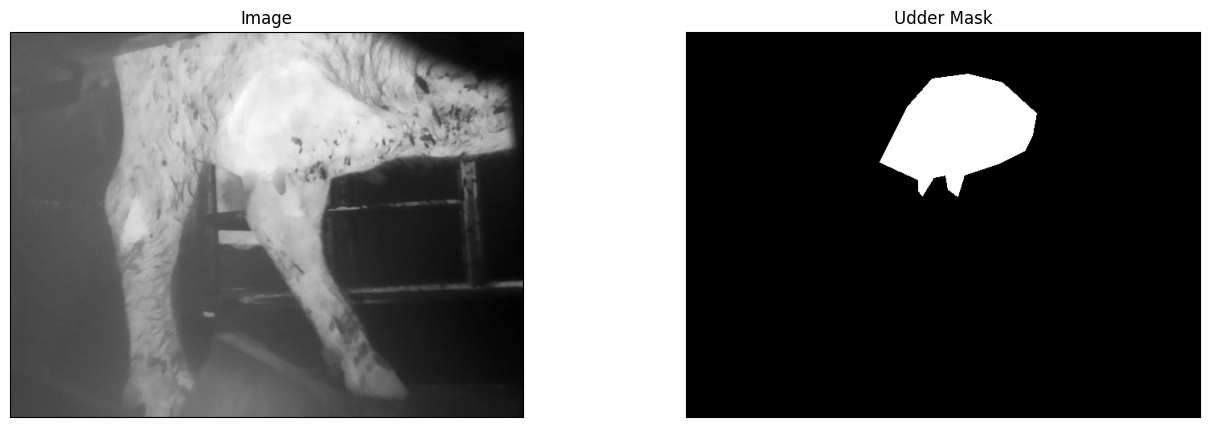

In [64]:
# Example usage
dataset = UdderDataset(
    clean_images_dir="data/clean/images/train",
    clean_masks_dir="data/clean/masks/train",
    obstructed_images_dir="data/obstructed/images/train",
    augmentation=None,
)

# Get a sample
image, mask, label = dataset[-1]

# Visualize
print(f"Image shape: {image.shape}, Mask shape: {mask.shape}, Label: {label}")
visualize(
    image=image,
    udder_mask=mask,
)

In [65]:
import albumentations as A

# TODO: Try to implement CutMix
def get_training_augmentation():
    """Modified for 1-channel images, excludes vertical flips and color space changes"""
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(
            scale_limit=0.2,
            rotate_limit=20,
            shift_limit=0.1,
            border_mode=cv2.BORDER_CONSTANT,
            p=0.5,
        ),
        A.Perspective(
            scale=(0.05, 0.2),
            border_mode=cv2.BORDER_CONSTANT,
            p=0.5,
        ),
        A.OneOf(
            [A.Sharpen(p=1), A.Blur(p=1)],
            p=0.5,
        ),
        A.GaussNoise(std_range=(0.1, 0.4), p=0.5),
        A.PadIfNeeded(min_height=480, min_width=640, border_mode=cv2.BORDER_CONSTANT),
    ]
    return A.Compose(train_transform, additional_targets={"mask": "mask"})


def get_validation_augmentation():
    """Padding suitable for 1-channel images"""
    test_transform = [
        A.PadIfNeeded(min_height=480, min_width=640, border_mode=cv2.BORDER_CONSTANT)
    ]
    return A.Compose(test_transform, additional_targets={"mask": "mask"})

In [66]:
# Training Dataset
train_dataset = UdderDataset(
    clean_images_dir="data/clean/images/train",
    clean_masks_dir="data/clean/masks/train",
    obstructed_images_dir="data/obstructed/images/train",
    augmentation=get_training_augmentation(),
)

# Validation Dataset
valid_dataset = UdderDataset(
    clean_images_dir="data/clean/images/val",
    clean_masks_dir="data/clean/masks/val",
    obstructed_images_dir="data/obstructed/images/val",
    augmentation=get_validation_augmentation(),
)

# Test Dataset
test_dataset = UdderDataset(
    clean_images_dir='data/test_clean/images',
    clean_masks_dir='data/test_clean/masks',
    obstructed_images_dir='data/test_obstructed/images',
    augmentation=get_validation_augmentation()
)

In [67]:
from torch.utils.data import DataLoader

BATCH_SIZE = 8

# TODO: num_workers = 4
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

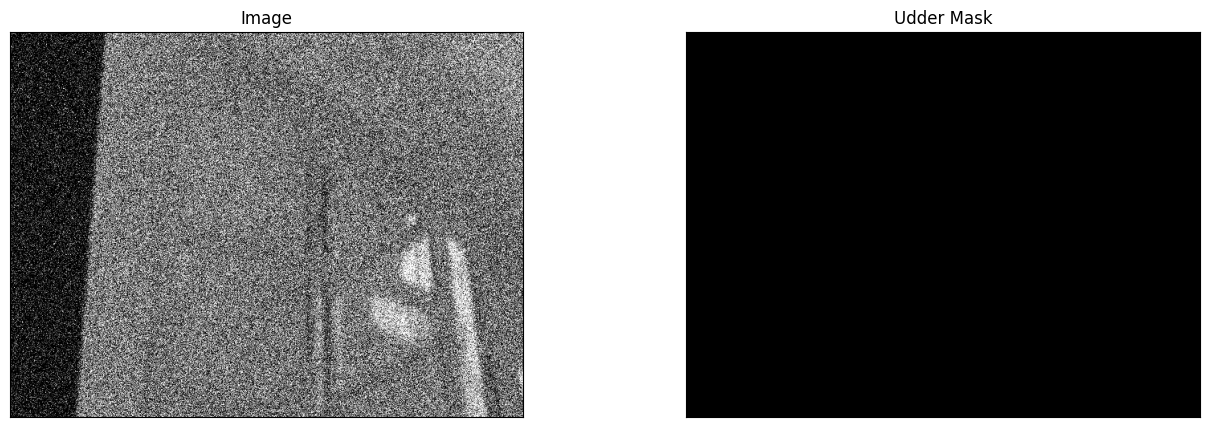

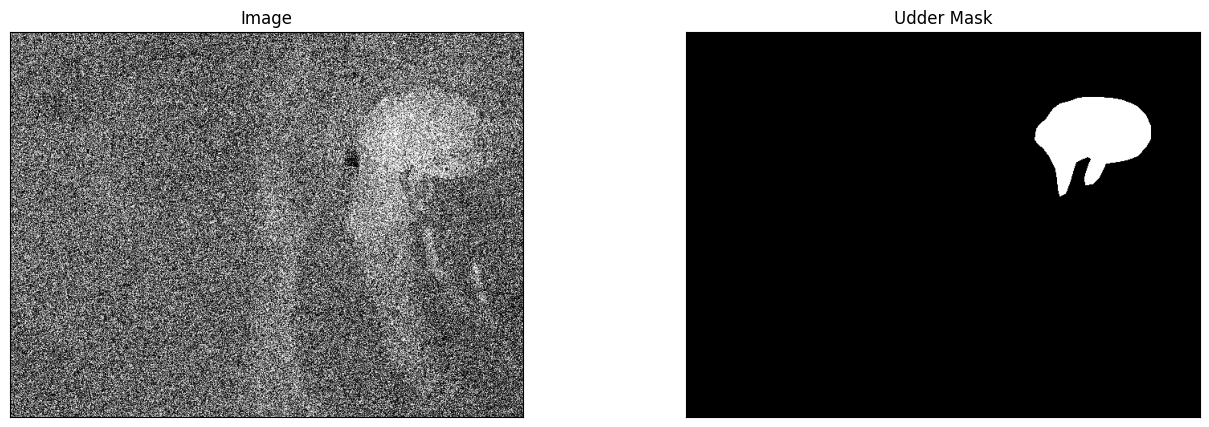

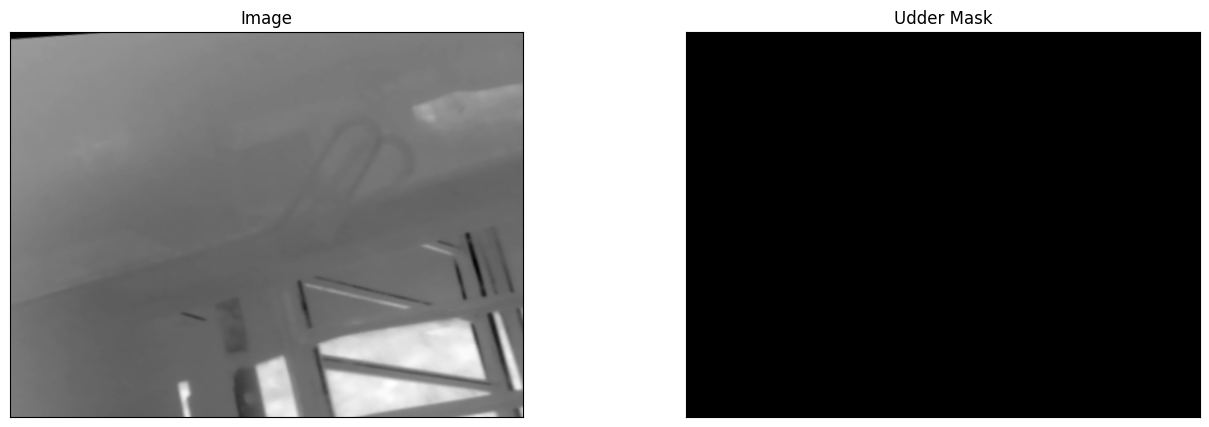

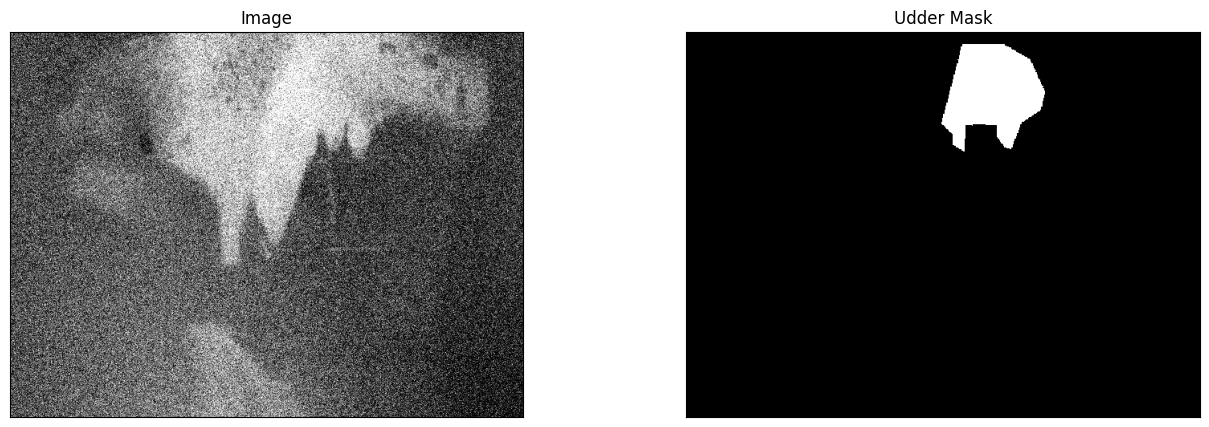

In [68]:
for i in range(2):
    # Get a clean sample
    image, mask, label = train_dataset[i]
    visualize(
        image=image,
        udder_mask=mask,
    )

    # Get an obstructed sample
    image, mask, label = train_dataset[len(train_dataset.clean_images) + i]
    visualize(
        image=image,
        udder_mask=mask,
    )

In [69]:
import torch
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from torch.optim import lr_scheduler

EPOCHS = 10

class UdderModel(pl.LightningModule):
    def __init__(
        self, arch, encoder_name, in_channels, out_classes, aux_params, **kwargs
    ):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            aux_params=aux_params,
            **kwargs,
        )

        # Preprocessing parameters for encoder
        params = smp.encoders.get_preprocessing_params(encoder_name)
        mean_val = sum(params["mean"]) / len(params["mean"])
        std_val = sum(params["std"]) / len(params["std"])
        self.register_buffer("std", torch.tensor([std_val]).view(1, 1, 1, 1))
        self.register_buffer("mean", torch.tensor([mean_val]).view(1, 1, 1, 1))

        # Loss functions
        self.seg_dice_loss = smp.losses.DiceLoss(mode="binary", from_logits=True)
        self.seg_bce_loss = smp.losses.SoftBCEWithLogitsLoss(smooth_factor=None)
        self.cls_loss = smp.losses.SoftBCEWithLogitsLoss(smooth_factor=None)

        # Metrics storage
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # Normalize and forward pass
        image = (image - self.mean) / self.std
        return self.model(image)

    def shared_step(self, batch, stage):
        image, mask_true, label_true = batch
        mask_pred, label_pred = self.forward(image)

        # Convert label_true to proper shape
        label_true = label_true.float().view(-1)  # Shape [B]

        # Create clean sample mask
        is_clean = label_true == 1  # Boolean mask shape [B]

        # Calculate segmentation loss only for clean samples
        seg_loss = torch.tensor(0.0, device=self.device)
        if is_clean.any():
            # Select only clean samples
            clean_mask_pred = mask_pred[is_clean]
            clean_mask_true = mask_true[is_clean]

            # Calculate losses on clean samples only
            seg_dice = self.seg_dice_loss(clean_mask_pred, clean_mask_true)
            seg_bce = self.seg_bce_loss(clean_mask_pred, clean_mask_true)
            seg_loss = seg_dice + seg_bce

        # Classification loss for all samples
        cls_loss = self.cls_loss(label_pred.squeeze(1), label_true)

        # Total loss
        total_loss = seg_loss + cls_loss

        # Loss metrics calculation
        metrics = {
            "loss": total_loss,
            "cls_loss": cls_loss.detach(),
            "seg_loss": seg_loss.detach() # if is_clean.any() else torch.tensor(0.0),
        }

        # Classification metrics
        pred_labels = (label_pred.sigmoid() > 0.5).float()
        metrics.update(
            {
                "cls_tp": ((pred_labels == 1) & (label_true == 1)).sum(),
                "cls_fp": ((pred_labels == 1) & (label_true == 0)).sum(),
                "cls_fn": ((pred_labels == 0) & (label_true == 1)).sum(),
                "cls_tn": ((pred_labels == 0) & (label_true == 0)).sum(),
            }
        )

        # Segmentation metrics only for clean samples
        if is_clean.any():
            with torch.no_grad():
                prob_mask = mask_pred[is_clean].sigmoid()
                pred_mask = (prob_mask > 0.5).float()
                tp, fp, fn, tn = smp.metrics.get_stats(
                    pred_mask.long(), mask_true[is_clean].long(), mode="binary"
                )
                metrics.update({"seg_tp": tp, "seg_fp": fp, "seg_fn": fn, "seg_tn": tn})

        return metrics

    def shared_epoch_end(self, outputs, stage):
        # Aggregate losses
        avg_loss = self.all_gather(torch.stack([x["loss"] for x in outputs])).mean()
        avg_cls_loss = self.all_gather(torch.stack([x["cls_loss"] for x in outputs])).mean()
        avg_seg_loss = self.all_gather(torch.stack([x["seg_loss"] for x in outputs])).mean()

        # Aggregate segmentation metrics
        if any("seg_tp" in x for x in outputs):
            seg_tp = self.all_gather(torch.cat([x["seg_tp"] for x in outputs if "seg_tp" in x]))
            seg_fp = self.all_gather(torch.cat([x["seg_fp"] for x in outputs if "seg_fp" in x]))
            seg_fn = self.all_gather(torch.cat([x["seg_fn"] for x in outputs if "seg_fn" in x]))
            seg_tn = self.all_gather(torch.cat([x["seg_tn"] for x in outputs if "seg_tn" in x]))
            iou = smp.metrics.iou_score(seg_tp, seg_fp, seg_fn, seg_tn, reduction="micro")
        else:
            iou = torch.tensor(float("nan"))

        # Aggregate classification metrics
        cls_tp = self.all_gather(torch.stack([x["cls_tp"] for x in outputs])).sum()
        cls_fp = self.all_gather(torch.stack([x["cls_fp"] for x in outputs])).sum()
        cls_fn = self.all_gather(torch.stack([x["cls_fn"] for x in outputs])).sum()
        cls_tn = self.all_gather(torch.stack([x["cls_tn"] for x in outputs])).sum()
        clean_cls_precision = cls_tp / (cls_tp + cls_fp + 1e-8)
        clean_cls_recall = cls_tp / (cls_tp + cls_fn + 1e-8)
        clean_cls_f1 = (
            2
            * clean_cls_precision
            * clean_cls_recall
            / (clean_cls_precision + clean_cls_recall + 1e-8)
        )

        self.log_dict(
            {
                f"{stage}_total_loss": avg_loss,
                f"{stage}_cls_loss": avg_cls_loss,
                f"{stage}_seg_loss": avg_seg_loss,
                f"{stage}_seg_iou": iou,
                f"{stage}_cls_f1": clean_cls_f1,
            },
            prog_bar=True,
            sync_dist=True,
        )

    def training_step(self, batch, batch_idx):
        metrics = self.shared_step(batch, "train")
        self.training_step_outputs.append(metrics)
        return metrics

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        self.training_step_outputs.clear()

    def validation_step(self, batch, batch_idx):
        metrics = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(metrics)
        return metrics

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        metrics = self.shared_step(batch, "test")
        self.test_step_outputs.append(metrics)
        return metrics

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=EPOCHS * len(train_loader), eta_min=1e-5
        )
        return [optimizer], [scheduler]

In [70]:
aux_params = dict(
    pooling="avg",
    dropout=0.5,
    activation=None,  # No activation for BCEWithLogitsLoss
    classes=1,  # Binary classification
)

model = UdderModel(
    arch="Unet",
    encoder_name="resnet34",
    in_channels=1,  # 1-channel input
    out_classes=1,  # Binary segmentation
    aux_params=aux_params,
)

In [ ]:
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    devices=-1,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    strategy="ddp_notebook",
    sync_batchnorm=True,
    log_every_n_steps=1,
)

trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
)

In [ ]:
# Define directories for test data
TEST_CLEAN_IMAGES_DIR = "data/clean/images/test"
TEST_CLEAN_MASKS_DIR = "data/clean/masks/test"
TEST_OBSTRUCTED_IMAGES_DIR = "data/obstructed/images/test"

# Create the test dataset using the validation augmentation
test_dataset = UdderDataset(
    clean_images_dir=TEST_CLEAN_IMAGES_DIR,
    clean_masks_dir=TEST_CLEAN_MASKS_DIR,
    obstructed_images_dir=TEST_OBSTRUCTED_IMAGES_DIR,
    augmentation=get_validation_augmentation(),
)

# Create the test dataloader
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

# Initialize the model
aux_params = {
    "pooling": "avg",
    "dropout": 0.5,
    "activation": None,
    "classes": 1,
}

model_args = {
    "arch": "Unet",
    "encoder_name": "resnet34",
    "in_channels": 1,
    "out_classes": 1,
    "aux_params": aux_params
}

# Initialize the PyTorch Lightning trainer
trainer = pl.Trainer(
    devices=-1,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
)

# Run the test loop
results = trainer.test(model, dataloaders=test_loader)
print(results)